# Joint RV & transit fits, TOI 1199

In [2]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares


import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import os
import warnings
os.environ["MKL_THREADING_LAYER"] = "GNU"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

## Datasets and initializations
Lets start with the transits from TESS

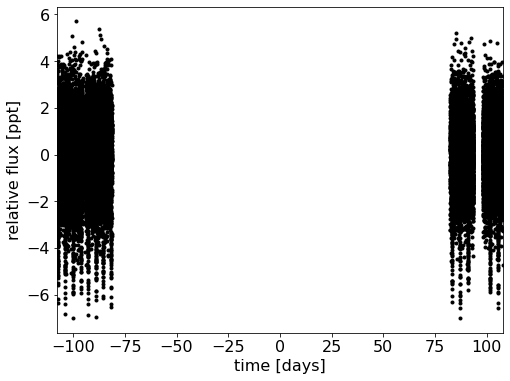

In [3]:
search_result = lk.search_lightcurve('TIC 99869022', author='SPOC')

lc_file = lk.search_lightcurve('TIC 99869022', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux


with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.plot(x_, y_, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x_.min(), x_.max())
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

In [4]:
period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x_, y_, yerr)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)

bls period: 3.6714776169735264
bls t0: -107.45144712249176
bls depth: 3.2197984867994087
ref_time: 2527.9875009679236
epoch: 2420.536053845432


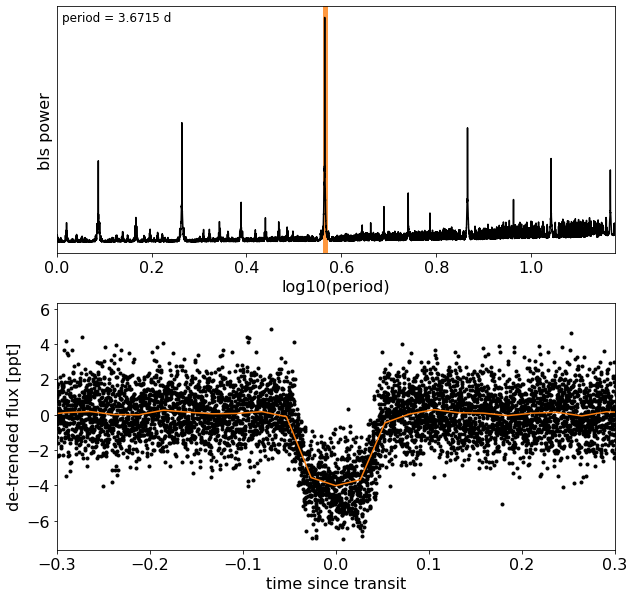

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax.plot(x_fold_, y_, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")
#plt.savefig('bls_1199.png',dpi=300,bbox_inches='tight')

(-0.3, 0.3)

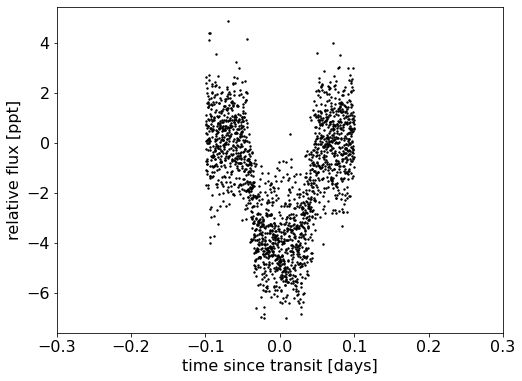

In [6]:
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
plt.xlim(-0.3,0.3)

Now the SOPHIE RVs.

52


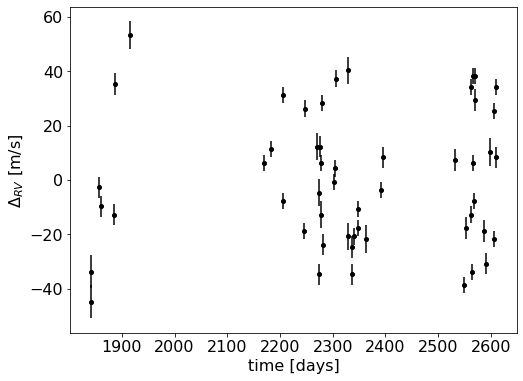

In [7]:
data = pd.read_table('1199_preliminary_rv_sophie.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err'}, inplace=True)

x_rv = np.array(data.bjd-2457000)
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [34]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 2000)

# We know the period and transit epoch from the BLS from TESS data
# let's estimate the expected semi-amplitude K for the planet

#period from exofop 3.6714634 +- 0.000004
#t0 from exofop: 2459618.796703 +- 0.0006
K = xo.estimate_semi_amplitude(period, x_rv, y_rv, yerr_rv, t0s=t0)
print(K, "m/s")

# Stellar parameters from Sousa
M_star = 1.18, 0.02
R_star = 1.45, 0.05

[30.02228134] m/s


Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [10]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(
    period, x_rv, y_rv, yerr_rv, t0s=t0, m_star=M_star[0]
)
msini = msini.to(u.M_earth)
print(msini)

[71.94306341] earthMass


## Joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.

In [46]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes (we already defined 't' for the rv model)
phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:
        
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=5.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)


        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit jitter
        logs = pm.Uniform("logs", lower=0, upper=1,testval=np.log(np.std(y)))

        # Wide log-normal prior for semi-amplitude
        logK = pm.Normal("logK", mu=np.log(K.item()), sd=2.0)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)* 1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * logs))
        pm.Normal("obs_rv", mu=rv_model, sd=err, observed=y_rv)

        # The likelihood for the light curve
        pm.Normal("obs_lc", mu=light_curve, sd=tt.exp(logs), observed=y[mask])
        
        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred",
            1e3 * star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp)[..., 0],)

        # Fit for the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[logs])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth, b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[logs]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = pmx.eval_in_model(light_curves, map_soln)

    return model, map_soln, extras

model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -6689.894405282506 -> -6559.576578413444
optimizing logp for variables: [b, log_depth]


message: Optimization terminated successfully.
logp: -6559.576578413444 -> -6395.49105015161
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -6395.49105015161 -> -5697.400590746441
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -5697.400590746441 -> -5696.643463777248
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -5696.643463777248 -> -5696.53446924685
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -5696.53446924685 -> -5690.088529955914
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -5690.088529955914 -> -5689.9723948242645
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -5689.9723948242645 -> -5507.02680095608
optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -5507.02680095608 -> -5506.593829099692
optimizing logp for variables: [logK, logs, trend, log_sigma_rv, ecs, log_depth, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -5506.593829099692 -> -5186.063053027204


In [47]:
model0.basic_RVs

[mean ~ Normal,
 u_star_quadlimbdark__ ~ TransformedDistribution,
 m_star_interval__ ~ TransformedDistribution,
 r_star_interval__ ~ TransformedDistribution,
 t0 ~ Normal,
 log_m_pl ~ Normal,
 log_period ~ Normal,
 b_interval__ ~ TransformedDistribution,
 log_depth ~ Normal,
 ecs_unitdisk+interval__ ~ TransformedDistribution,
 log_sigma_rv ~ Normal,
 trend ~ Normal,
 logs_interval__ ~ TransformedDistribution,
 logK ~ Normal,
 ecc_prior ~ Beta,
 obs_rv ~ Normal,
 obs_lc ~ Normal]

Now let's plot the map radial velocity model.

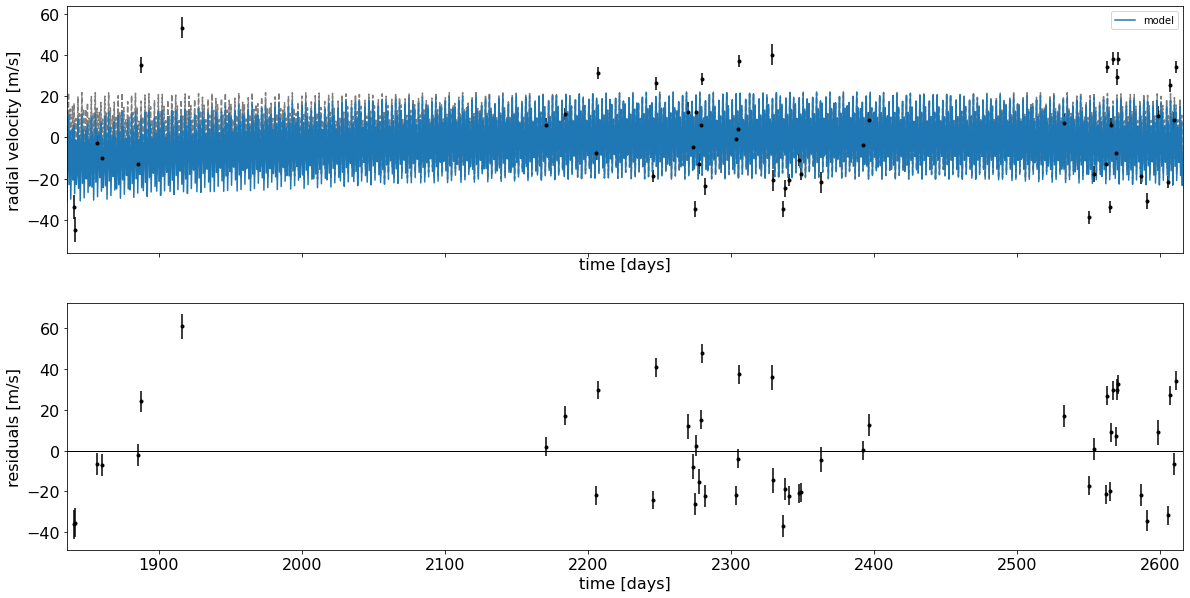

In [48]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")

    ax.plot(t, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t, soln['rv_model_pred'], label="model")

    ax.legend(fontsize=10)
    ax.set_xlim(t.min(), t.max())
    #plt.xlim(2200,2300)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    

    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t.min(), t.max())
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln0)

Now let's also plot the transit model.

Text(0, 0.5, 'relative flux [ppt]')

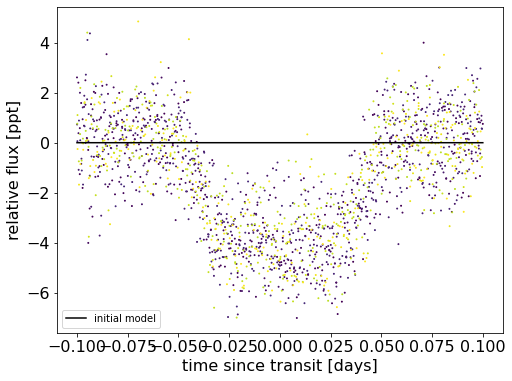

In [45]:
# Plot the data as above
plt.scatter(x_fold, y, c=x, s=0.9)

# Compute the initial transit model evaluated at each data point
# and overplot that
#with model:
#    transit_model = xo.utils.eval_in_model(light_curve)

# For plotting purposes, sort the folded times
inds = np.argsort(x_fold)
plt.plot(x_fold[inds], extras0[inds], "k", label="initial model")
plt.legend(fontsize=10, loc=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")

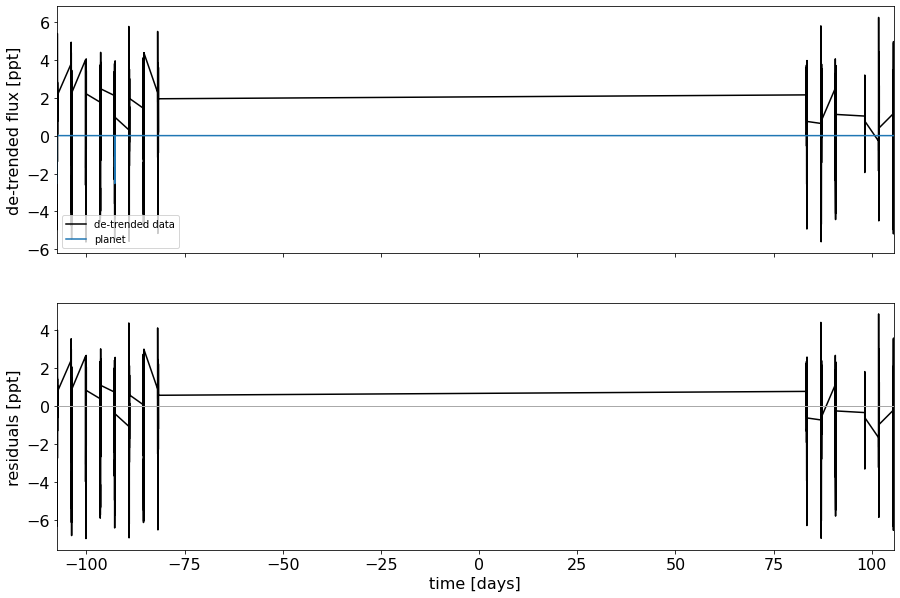

In [52]:
# We plot the initial light curve model:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask] - soln['mean'], "k", label="de-trended data")
    mod = extras
    ax.plot(x[mask], mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[1]
    mod = np.sum(extras, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    #plt.xlim(-274,-270)
    return fig


_ = plot_light_curve(map_soln0, extras0)

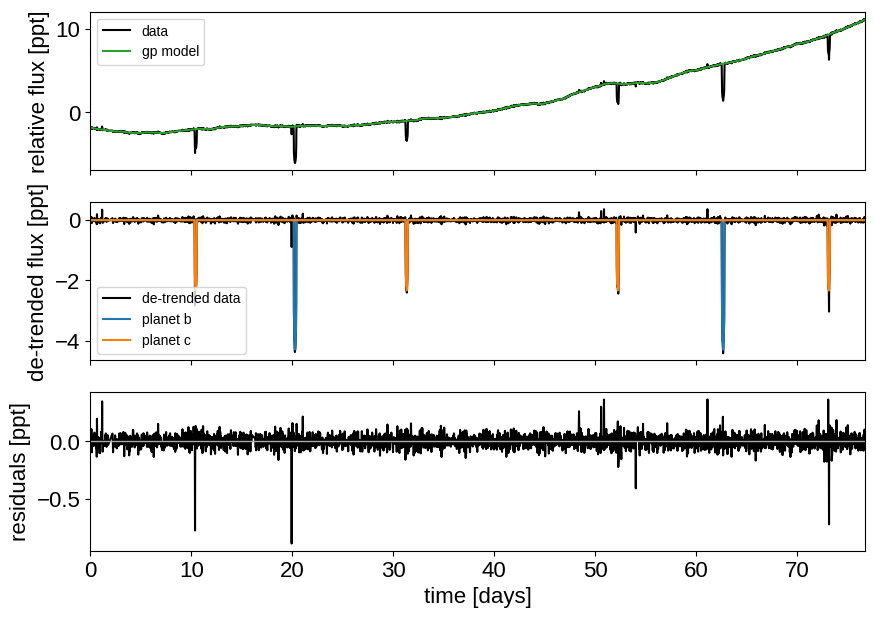

In [10]:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean_flux"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

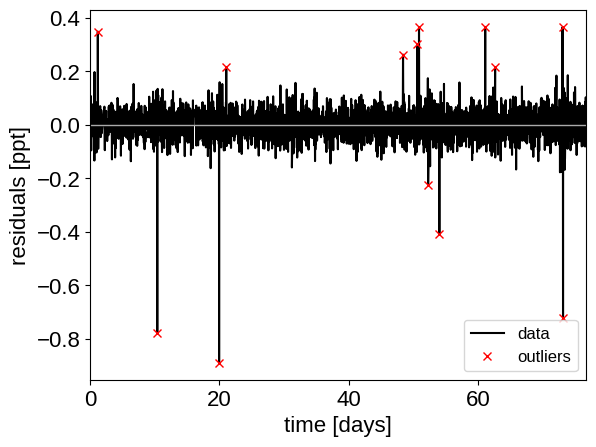

In [11]:
mod = (
    extras0["gp_pred"]
    + map_soln0["mean_flux"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
_ = plt.xlim(x.min(), x.max())

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]


message: Desired error not necessarily achieved due to precision loss.
logp: 5186.334921261539 -> 5186.334921261539


optimizing logp for variables: [log_sigma_lc]


message: Optimization terminated successfully.
logp: 5186.334921261539 -> 5268.249912515486


optimizing logp for variables: [b, log_depth]


message: Optimization terminated successfully.
logp: 5268.249912515486 -> 5279.213408252534


optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 5279.213408252535 -> 5280.695848335159


optimizing logp for variables: [log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: 5280.695848335154 -> 5281.428983342169


optimizing logp for variables: [log_rho_gp]


message: Optimization terminated successfully.
logp: 5281.428983342169 -> 5281.430247202541


optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, trend, log_sigma_rv, ecs, log_depth, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: 5281.430247202544 -> 5282.934434028059


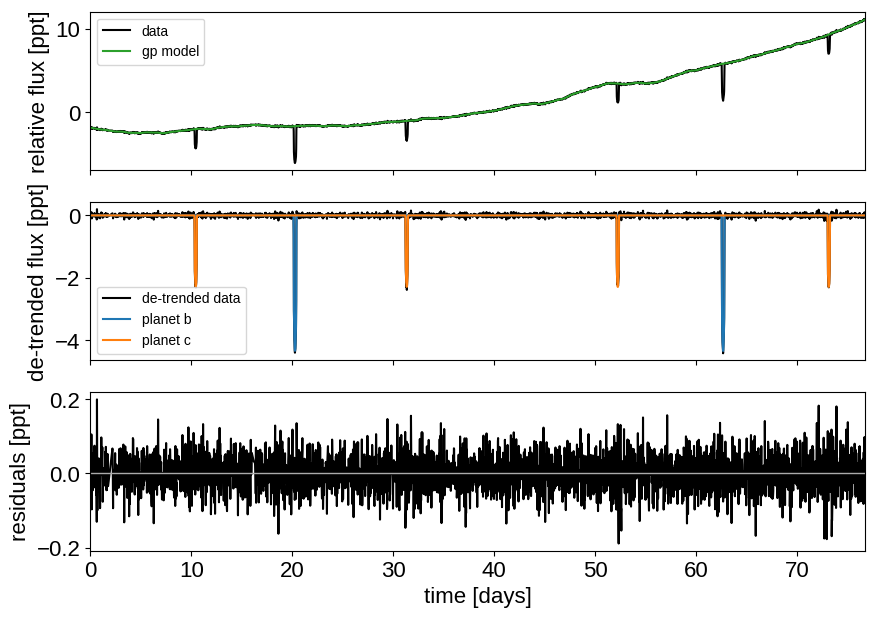

In [12]:
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer.
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter, eccentricity, and radius/radius ratio).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot longer to get thousands of effective samples!

In [13]:
import multiprocessing

with model:
    trace = pm.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],
        mp_ctx=multiprocessing.get_context("fork"),
        init="adapt_full",
    )

Auto-assigning NUTS sampler...


Initializing NUTS using adapt_full...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, trend, log_sigma_rv, ecs, log_depth, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean_flux]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 848 seconds.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8825889578919156, but should be close to 0.95. Try to increase the number of tuning steps.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [14]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "period",
        "r_pl",
        "m_pl",
        "ecc",
        "omega",
        "b",
        "log_sigma_gp",
        "log_rho_gp",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],42.363,0.000,42.363,42.364,0.000,0.000,2009.0,1245.0,1.00
period[1],20.885,0.000,20.885,20.886,0.000,0.000,2323.0,1428.0,1.00
r_pl[0],0.078,0.005,0.068,0.085,0.000,0.000,322.0,262.0,1.01
r_pl[1],0.056,0.004,0.048,0.062,0.000,0.000,245.0,235.0,1.01
m_pl[0],26.822,5.749,16.716,38.795,0.154,0.109,1386.0,889.0,1.00
m_pl[1],21.726,4.394,13.324,30.235,0.124,0.087,1278.0,998.0,1.00
ecc[0],0.040,0.042,0.000,0.095,0.003,0.002,571.0,344.0,1.00
ecc[1],0.085,0.082,0.000,0.260,0.003,0.002,818.0,1017.0,1.00
omega[0],0.205,2.029,-3.024,2.998,0.083,0.058,921.0,1498.0,1.00
omega[1],-0.387,1.088,-2.944,1.676,0.038,0.027,868.0,1250.0,1.00


As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

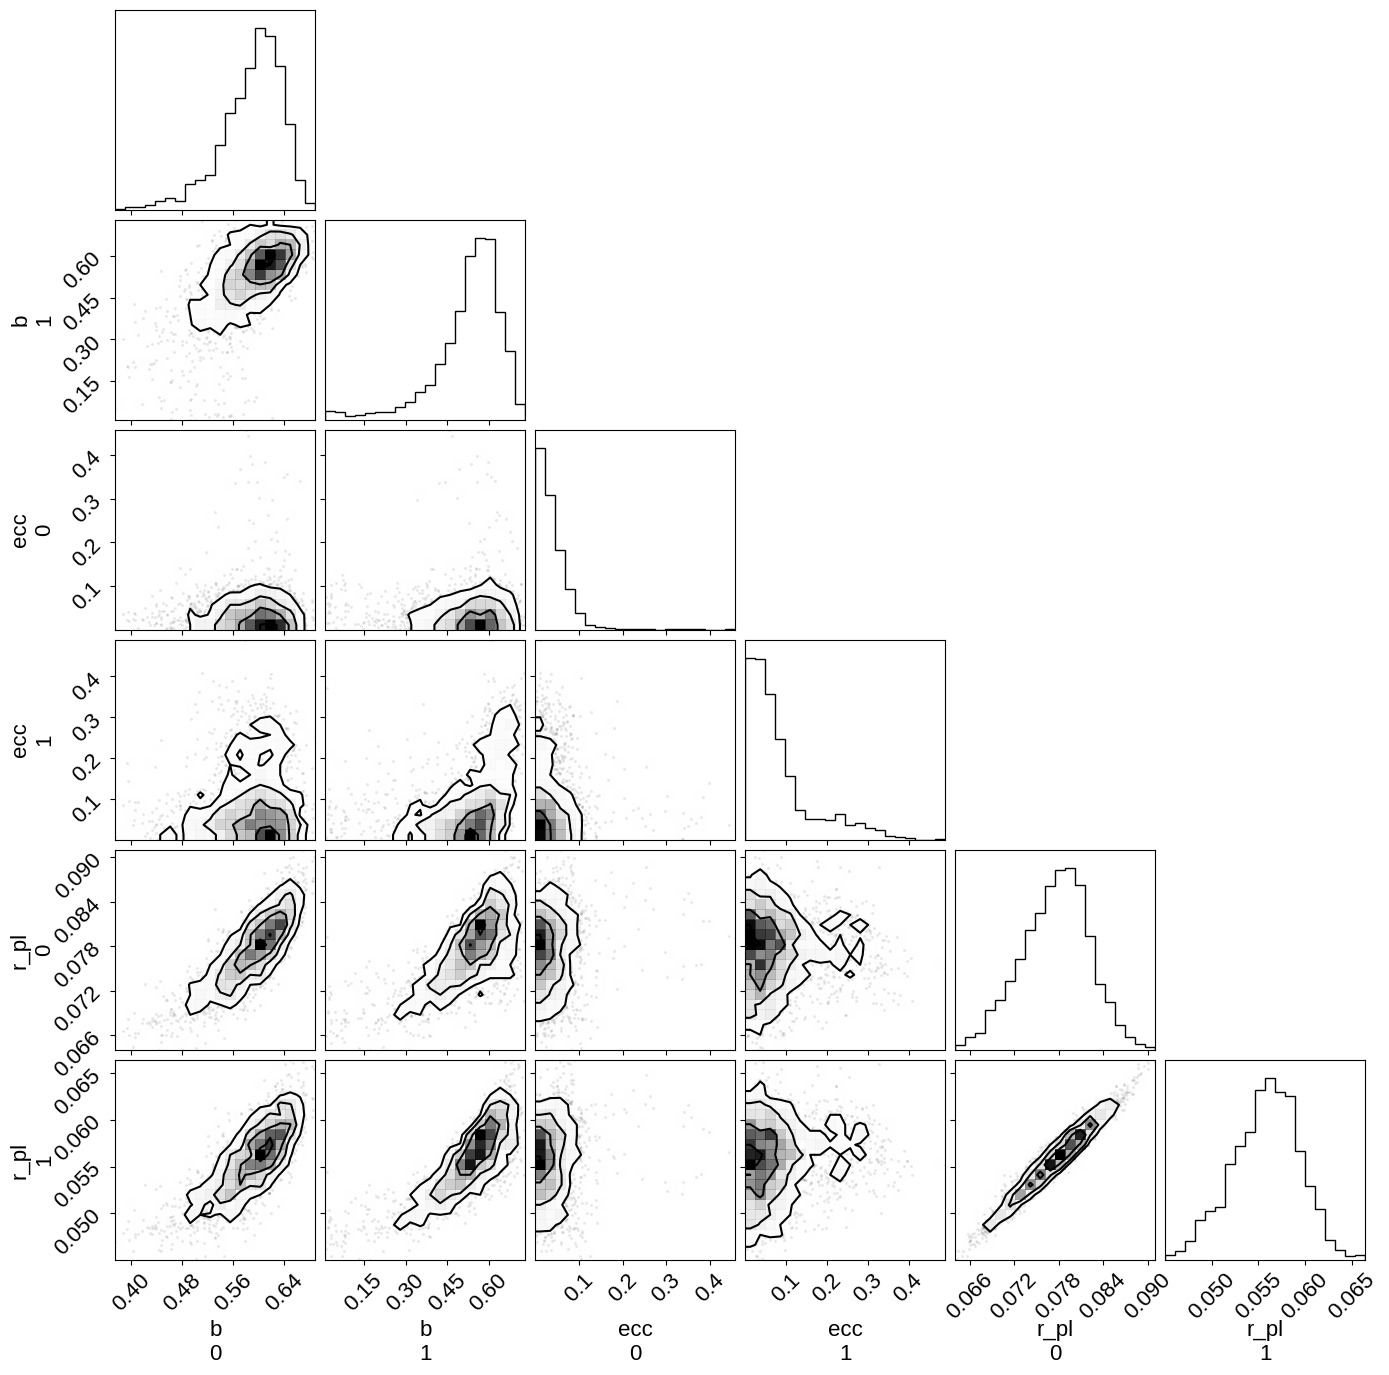

In [15]:
import corner

_ = corner.corner(trace, var_names=["b", "ecc", "r_pl"])

## Phase plots

Finally, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

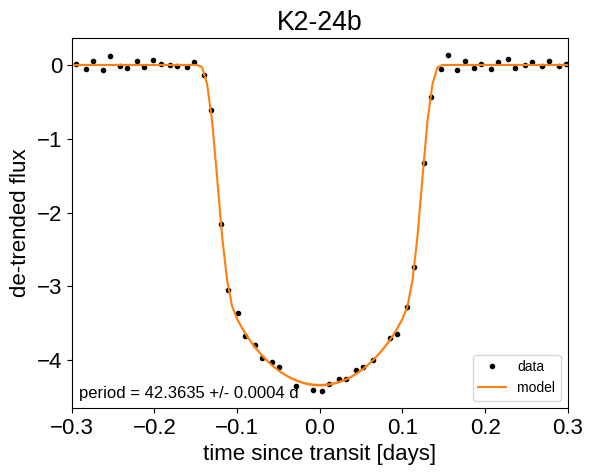

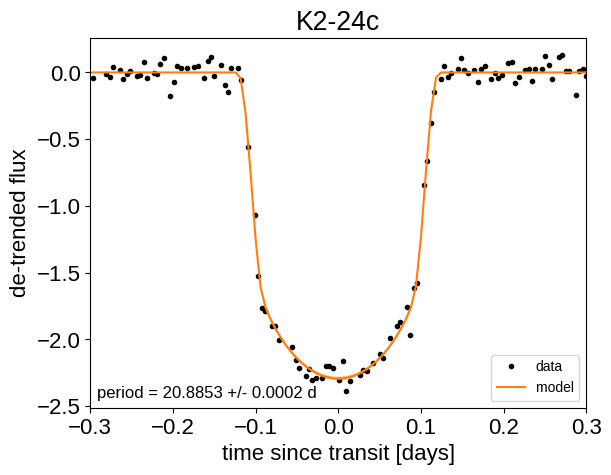

In [16]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))
gp_mod = extras["gp_pred"] + map_soln["mean_flux"]

for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(flat_samps["period"][n])
    t0 = np.median(flat_samps["t0"][n])

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.3
    plt.plot(
        x_fold[m], y[mask][m] - gp_mod[m], ".k", label="data", zorder=-1000
    )

    # Plot the folded model
    pred = np.percentile(flat_samps["lc_pred"][:, n, :], [16, 50, 84], axis=-1)
    plt.plot(phase_lc, pred[1], color="C1", label="model")
    art = plt.fill_between(
        phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(flat_samps["period"][n].values),
        np.std(flat_samps["period"][n].values),
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter))
    plt.xlim(-0.3, 0.3)

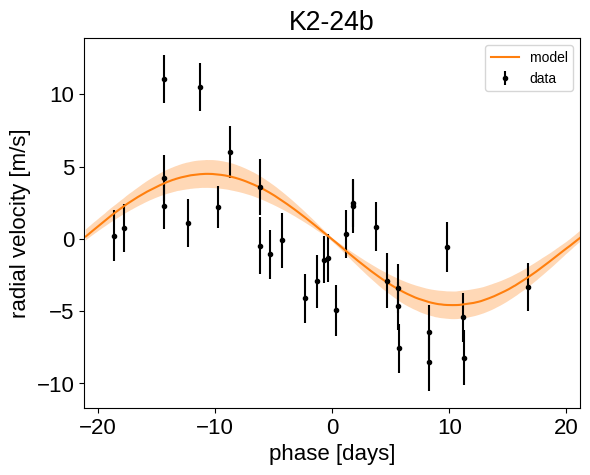

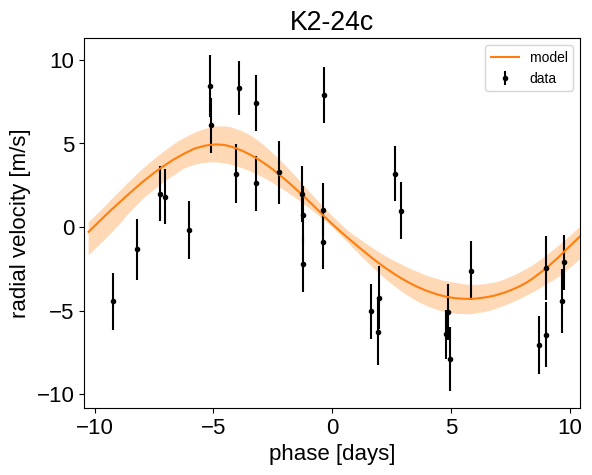

In [17]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(flat_samps["period"][n])
    t0 = np.median(flat_samps["t0"][n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(flat_samps["vrad"][:, (n + 1) % 2], axis=-1)
    other += np.median(flat_samps["bkg"], axis=-1)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        flat_samps["vrad_pred"][inds, n], [16, 50, 84], axis=-1
    )
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

We can also compute the posterior constraints on the planet densities.

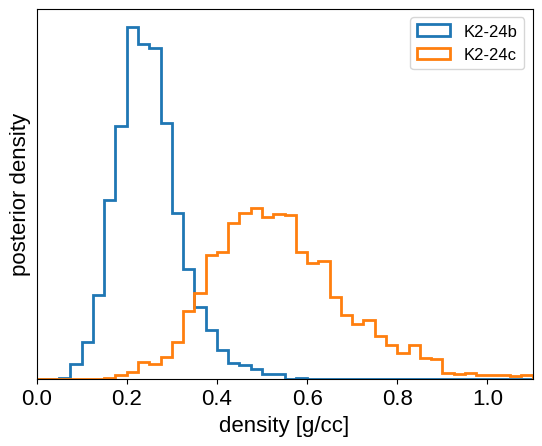

In [18]:
volume = 4 / 3 * np.pi * flat_samps["r_pl"].values ** 3
density = u.Quantity(
    flat_samps["m_pl"].values / volume, unit=u.M_earth / u.R_sun**3
)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):
    plt.hist(
        density[n],
        bins,
        histtype="step",
        lw=2,
        label="K2-24{0}".format(letter),
        density=True,
    )
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [19]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{celerite2:foremanmackey17,
celerite2:foremanmackey18, exoplanet:agol20, exoplanet:arviz,
exoplanet:astropy13, exoplanet:astropy18, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano, exoplanet:vaneylen19}.


In [20]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System